<a href="https://colab.research.google.com/github/rcantini/BERT_personality_detection/blob/main/BERT_personality_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Personality detection using BERT**

## Set the environment

Download the required dependencies

In [ ]:
!pip install -r requirements.txt

Import necessary libraries

In [22]:
import pandas as pd
from transformers import TFBertModel, BertTokenizer
seed_value = 29
import os
os.environ['PYTHONHASHSEED'] = str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
np.set_printoptions(precision=2)
import tensorflow as tf
tf.random.set_seed(seed_value)
import tensorflow_addons as tfa
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.callbacks import ModelCheckpoint
import re
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve

Enable GPU processing

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

## Model training
I modeled personality detection on the **MBTI** dataset as a multilabel classification task.

In particular, the model treats each personality axis as a separate class, computing an independent probability for each one of them through a Bernuolli trial.

The model is based on **BERT** (HuggingFace Transfomers) and exploits the effectiveness of transfer learning from pre-trained language representation models.

In [21]:
N_AXIS = 4
MAX_SEQ_LEN = 128
BERT_NAME = 'bert-base-uncased'
'''
EMOTIONAL AXES:
Introversion (I) – Extroversion (E)
Intuition (N) – Sensing (S)
Thinking (T) – Feeling (F)
Judging (J) – Perceiving (P)
'''
axes = ["I-E","N-S","T-F","J-P"]
classes = {"I":0, "E":1, # axis 1
           "N":0,"S":1, # axis 2
           "T":0, "F":1, # axis 3
           "J":0,"P":1} # axis 4

### Preprocessing
The following operation are performed: text lowercasing, removing text in square brackets, links, words containing numbers, emoji and initial single quotes.

In [4]:
def text_preprocessing(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text.encode('ascii', 'ignore').decode('ascii')
    if text.startswith("'"):
        text = text[1:-1]
    return text

Load MBTI data, splitting it into train, val and test skipping the last incomplete batch.

In [5]:
train_n=6624
val_n=1024
test_n=1024
data = pd.read_csv("mbti_1.csv")
data = data.sample(frac=1)
labels = []
print(data)
for personality in data["type"]:
    pers_vect = []
    for p in personality:
        pers_vect.append(classes[p])
    labels.append(pers_vect)
sentences = data["posts"].apply(str).apply(lambda x: text_preprocessing(x))
labels = np.array(labels, dtype="float32")
train_sentences = sentences[:train_n]
y_train = labels[:train_n]
val_sentences = sentences[train_n:train_n+val_n]
y_val = labels[train_n:train_n+val_n]
test_sentences = sentences[train_n+val_n:train_n+val_n+test_n]
y_test = labels[train_n+val_n:train_n+val_n+test_n]

      type                                              posts
4420  INFP  i guess he's just preparing for wwIII, which w...
7570  ENTJ  'More like whenever we start talking about any...
2807  INFP  'I have this really strange fear of shiny jewe...
463   ISTP  'Exactly!   :cheers2:|||Same here! So curious....
3060  INFJ  'May I pop in?  I've been struggling with perf...
...    ...                                                ...
920   INFP  'Those are excellent examples and explanation,...
864   INTP  'I was thinking the same.|||we do that sometim...
808   ISTP  'Associate in Professional Flight Technology||...
6380  INFJ  'I just love this...  https://www.youtube.com/...
8149  INTJ  'I haven't posted here in a while.  Forgive me...

[8675 rows x 2 columns]


Encode sentences following the BERT specifications

In [6]:
def prepare_bert_input(sentences, seq_len, bert_name):
    tokenizer = BertTokenizer.from_pretrained(bert_name)
    encodings = tokenizer(sentences.tolist(), truncation=True, padding='max_length',
                                max_length=seq_len)
    input = [np.array(encodings["input_ids"]), np.array(encodings["token_type_ids"]),
               np.array(encodings["attention_mask"])]
    return input

In [7]:
X_train = prepare_bert_input(train_sentences, MAX_SEQ_LEN, BERT_NAME)
X_val = prepare_bert_input(val_sentences, MAX_SEQ_LEN, BERT_NAME)
X_test = prepare_bert_input(test_sentences, MAX_SEQ_LEN, BERT_NAME)

### Model architecture

Encoded input is processed by the BERT model. Then, a Global Average Pooling on the sequence of all hidden states is used in order to get a concise representation of the whole sentence. Finally the output sigmoid layer compute an independent probability for each personality axis.

In [8]:
input_ids = layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name='input_ids')
input_type = layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name='token_type_ids')
input_mask = layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name='attention_mask')
inputs = [input_ids, input_type, input_mask]
bert = TFBertModel.from_pretrained(BERT_NAME)
bert_outputs = bert(inputs)
last_hidden_states = bert_outputs.last_hidden_state
avg = layers.GlobalAveragePooling1D()(last_hidden_states)
output = layers.Dense(N_AXIS, activation="sigmoid")(avg)
model = keras.Model(inputs=inputs, outputs=output)
model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

### End-to-end fine-tuning

The model is fully fine-tuned with a small learning rate in order to readapt the pre-trained features to work with our downstream task. I used a binary cross-entropy loss as the prediction for each personality axis is modeled like a single Bernoulli trial, estimating the probability through a sigmoid activation. Moreover I chose the Rectified version of ADAM (RAdam) as the optimizer for the training process. Lastly, I used the area under the Receiver Operating Characteristic curve (ROC AUC), and binary accuracy as the main metrics for validation and testing.

In [9]:
max_epochs = 7
batch_size = 32
opt = tfa.optimizers.RectifiedAdam(learning_rate=3e-5)
loss = keras.losses.BinaryCrossentropy()
best_weights_file = "weights.h5"
auc = keras.metrics.AUC(multi_label=True, curve="ROC")
m_ckpt = ModelCheckpoint(best_weights_file, monitor='val_'+auc.name, mode='max', verbose=2,
                          save_weights_only=True, save_best_only=True)
model.compile(loss=loss, optimizer=opt, metrics=[auc, keras.metrics.BinaryAccuracy()])
model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=max_epochs,
    batch_size=batch_size,
    callbacks=[m_ckpt],
    verbose=2
)

Epoch 1/7
207/207 - 226s - loss: 0.5899 - auc: 0.5325 - binary_accuracy: 0.6766 - val_loss: 0.5608 - val_auc: 0.6397 - val_binary_accuracy: 0.7034

Epoch 00001: val_auc improved from -inf to 0.63968, saving model to weights.h5
Epoch 2/7
207/207 - 192s - loss: 0.5275 - auc: 0.6807 - binary_accuracy: 0.7446 - val_loss: 0.5115 - val_auc: 0.7260 - val_binary_accuracy: 0.7551

Epoch 00002: val_auc improved from 0.63968 to 0.72596, saving model to weights.h5
Epoch 3/7
207/207 - 192s - loss: 0.4856 - auc: 0.7569 - binary_accuracy: 0.7662 - val_loss: 0.4999 - val_auc: 0.7492 - val_binary_accuracy: 0.7607

Epoch 00003: val_auc improved from 0.72596 to 0.74920, saving model to weights.h5
Epoch 4/7
207/207 - 192s - loss: 0.4354 - auc: 0.8146 - binary_accuracy: 0.7960 - val_loss: 0.5079 - val_auc: 0.7448 - val_binary_accuracy: 0.7559

Epoch 00004: val_auc did not improve from 0.74920
Epoch 5/7
207/207 - 192s - loss: 0.3572 - auc: 0.8827 - binary_accuracy: 0.8405 - val_loss: 0.5638 - val_auc: 0.733

## Results evaluation

Evaluate the model on the test set.

In [17]:
loss = keras.losses.BinaryCrossentropy()
best_weights_file = "weights.h5"
model.load_weights(best_weights_file)
opt = tfa.optimizers.RectifiedAdam(learning_rate=3e-5)
model.compile(loss=loss, optimizer=opt, metrics=[keras.metrics.AUC(multi_label=True, curve="ROC"),
                                                  keras.metrics.BinaryAccuracy()])
predictions = model.predict(X_test)
model.evaluate(X_test, y_test, batch_size=32)

32/32 [==============================] - 11s 274ms/step - loss: 0.5174 - auc_2: 0.7249 - binary_accuracy: 0.7500


[0.5088244080543518, 0.7356589436531067, 0.757080078125]

Plot ROC AUC for each personality axis.

In [23]:
def plot_roc_auc(y_test, y_score, classes):
    assert len(classes) > 1, "len classes must be > 1"
    plt.figure()
    if len(classes) > 2:  # multi-label
        # Compute ROC curve and ROC area for each class
        for i in range(len(classes)):
            fpr, tpr, _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label='ROC curve of class {0} (area = {1:0.2f})'.format(classes[i], roc_auc))
        # Compute micro-average ROC curve and ROC area
        fpr, tpr, _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc = auc(fpr, tpr)
        # Plot ROC curve
        plt.plot(fpr, tpr, label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc))
    else:
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

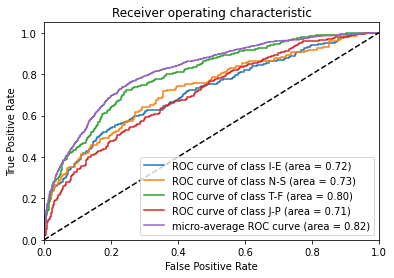

In [24]:
plot_roc_auc(y_test, predictions, axes)

As a final step, I tested the model with a simple sentence for finding out my personality. 

In [27]:
s1 = "I like studying deep learning, playing football, hanging out with my friends," \
     "listen to music and visit foreign cities all over the world."
sentences = np.asarray([s1])
enc_sentences = prepare_bert_input(sentences, MAX_SEQ_LEN, BERT_NAME)
predictions = model.predict(enc_sentences)
for sentence, pred in zip(sentences, predictions):
    pred_axis = []
    mask = (pred > 0.5).astype(bool)
    for i in range(len(mask)):
        if mask[i]:
            pred_axis.append(axes[i][2])
        else:
            pred_axis.append(axes[i][0])
    print('-- comment: '+sentence.replace("\n", "").strip() +
          '\n-- personality: '+str(pred_axis) +
          '\n-- scores:'+str(pred))

-- comment: I like studying deep learning, playing football, hanging out with my friends,listen to music and visit foreign cities all over the world.
-- personality: ['I', 'N', 'T', 'P']
-- scores:[0.18 0.44 0.36 0.79]
